# Analyzing marketing campaigns

**Description: Analyze the effectiveness of marketing campaign data (run for a month) for 100K samples**

- Determine how many unique users see a marketing campaign each day
- Assess Conversation Rate for entire duration of marketing campaigns
- Analyze the 1-month Retention Rate
- Determine the most effective subscribing channel (among House-Ads, Email, Facebook, Instagram and Push) contributing to the highest conversion and retention rates.
- Understand the most preferred language, and for which customer segmentation
- Which age group are most promising to get the biggest bang for the buck
- Which days of the week are most suitable to send out an ad
- Are there any data discrepancies and what impact do they have

## Import modules

In [1]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder


In [43]:
# Sklearn version used

import sklearn
sklearn.__version__

sklearn.show_versions()



System:
    python: 3.8.5 (default, Sep  4 2020, 02:22:02)  [Clang 10.0.0 ]
executable: /Users/ashishsharma/opt/anaconda3/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

Python dependencies:
          pip: 20.2.4
   setuptools: 50.3.1.post20201107
      sklearn: 0.24.1
        numpy: 1.20.2
        scipy: 1.5.2
       Cython: 0.29.21
       pandas: 1.2.4
   matplotlib: 3.4.1
       joblib: 0.17.0
threadpoolctl: 2.1.0

Built with OpenMP: True


## Configuration

In [2]:
pad = 50

## Helper Functions

In [3]:
def validate_input(dataframe, columns):
    """
    Validates user input before running functions
    that compute common metrics.
    
    Input:
        - dataframe {pd.DataFrame}: input df on which 
        conversion / retention rate is calculated
        - columns {str}: column names over which the 
        conversion retention rate will be computed
    
    Return:
        - {bool} True if all input is correct.
        ValueError raised if not.
    """
   
    # Validate type and value of columns parameter
    if isinstance(columns, str):
        if columns not in dataframe.columns:
            raise ValueError('Column provided does not exist in dataframe.')
    elif isinstance(columns, list):
        for col in columns:
            if col not in dataframe.columns:
                raise ValueError('Column {} does not exist in dataframe.'.format(col))
    else:
        raise TypeError('Provide either a string for 1 column or a list for multiple columns.')
    
    return True
    

In [4]:
def conversion_rate(dataframe, columns):
    """
    Calculates the conversion rate for data passed 
    as a dataframe to this function grouped on the 
    column(s) specified (which suggests that the
    conversion rate is computed over this aspect).
    
    Input:
        - dataframe {pd.DataFrame}: input df on which 
        conversion rate is calculated
        - columns {str/list}: column names over which the 
        conversion rate will be computed
    
    Return:
        - Computed Conversion rate
    """

    if validate_input(dataframe, columns):    
        
        # Group by columns and calculate # of converted users
        column_converted = dataframe[dataframe['converted']==True]\
        .groupby(columns)['user_id'].nunique()

        # Total # of converted users
        column_total = dataframe[dataframe['converted']==True]\
        ['user_id'].nunique()

        conversion_rate = column_converted / column_total

        return conversion_rate


In [5]:
def retention_rate(dataframe, columns):
    """
    Calculates the retention rate for data passed 
    as a dataframe to this function grouped on the 
    column(s) specified (which suggests that the
    retention rate is computed over this aspect).
    
    Input:
        - dataframe {pd.DataFrame}: input df on which 
        retention rate is calculated
        - columns {str/list}: column names over which the 
        retention rate will be computed
    
    Return:
        - Computed Retention rate
    """

    # Compute if validation of input is successful
    if validate_input(dataframe, columns):    
        
        # Group by columns and calculate retention
        retained = dataframe[dataframe['is_retained']==True]\
        .groupby(columns)['user_id'].nunique()

        # Group by columns and calculate conversion
        converted = dataframe[dataframe['converted']==True]\
        .groupby(columns)['user_id'].nunique()

        retention_rate = retained / converted

        return retention_rate


In [6]:
def plotting_various_retention_rates(dataframe):
    """
    Plots Retention Rates across various aspects
    that are defined by the values within a column.
    Example: "Marketing_channel" has different channels,
    and for each, a plot will be creating pertaining 
    to the retention rate metric for that channel.
    
    Input:
        - dataframe {pd.DataFrame}: input df on which 
        retention rate is calculated
        - columns {str}: column names over which the 
        retention rate will be computed
    
    Return:
        - {plt.plot} Retention rate plot
    """
    for column in dataframe:
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + column + ' retention rate', size=15)
        plt.ylabel('Retention Rate (%)')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.show()
        

## Read data

In [7]:
# There are 3 date columns which pandas
# will import as objects, so ensuring they
# are properly imported as datetime objects
data = pd.read_csv('./Data/marketing_dataset_1.csv', 
                   parse_dates=['date_served', 
                                'date_subscribed', 
                                'date_canceled'])
data.shape

(10037, 12)

In [8]:
# Examing few samples

data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True


## EDA and initial data prep

In [9]:
# Creating a backup before changes
df = data.copy()

In [10]:
# Converting string to bool

bool_workaround_dict = {'True':True, 
                        'False':False}

df['is_retained'].map(bool_workaround_dict, 
                      na_action='ignore'); # works even without this but is used to explicitly not take an action on missing values

In [11]:
# Verifying conversion

df['is_retained'].value_counts(dropna=False)

NaN      8181
True     1279
False     577
Name: is_retained, dtype: int64

In [12]:
# Checking against original df

data['is_retained'].value_counts(dropna=False)

NaN      8181
True     1279
False     577
Name: is_retained, dtype: int64

In [13]:
# Types of marketing channels
# Including NaN check within to checka

df['marketing_channel'].value_counts(dropna=False)

House Ads    4733
Instagram    1871
Facebook     1860
Push          993
Email         565
NaN            15
Name: marketing_channel, dtype: int64

In [14]:
# Replace NaN
df['marketing_channel'].fillna(value='not_specified', inplace=True)
df['marketing_channel'].value_counts(dropna=False)

House Ads        4733
Instagram        1871
Facebook         1860
Push              993
Email             565
not_specified      15
Name: marketing_channel, dtype: int64

In [15]:
# Converting marketing channel to codes to make it
# computational inexpensive and ML model ready

oe = OrdinalEncoder()

oe.fit_transform(df[['marketing_channel']])

oe.categories_

[array(['Email', 'Facebook', 'House Ads', 'Instagram', 'Push',
        'not_specified'], dtype=object)]

In [16]:
# Checking if the data columns are properly read
# or improperly read as objects by pandas
print(df['date_served'].dtype, 
      df['date_subscribed'].dtype, 
      df['date_canceled'].dtype)


datetime64[ns] datetime64[ns] datetime64[ns]


In [17]:
# Now that the conversion has happened, lets
# leverage dt data attribute for some useful information
# 0 = Monday, ... 7 = Sunday

df['day_served'] = df['date_served'].dt.dayofweek

#### Number of unique users

In [18]:
df['user_id'].nunique()

7309

#### Number of days the campaign has run so far

In [19]:
df['date_served'].nunique()

31

#### Did a user see a marketing asset more than once a day?

In [20]:
# Group by user and date the marketing asset was served
# use size to get the number of records of each group
# sort that by descending order to see values > 1 on top

df.groupby(['user_id', 'date_served']).size().sort_values(ascending=False)

user_id     date_served
a100000894  2018-01-03     6
a100000889  2018-01-03     6
a100000888  2018-01-02     6
a100000882  2018-01-02     4
a100000885  2018-01-02     4
                          ..
a100002089  2018-01-14     1
a100002090  2018-01-05     1
            2018-01-14     1
a100002091  2018-01-06     1
a100007294  2018-01-06     1
Length: 9741, dtype: int64

In [21]:
# Verifying a case where a user saw a marketing asset
# more than 1 a day

df.groupby(['user_id', 'date_served']).get_group(('a100000894','2018-01-03'))

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,day_served
1000,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,2.0
1001,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-12,NaT,Instagram,True,2.0
1002,a100000894,2018-01-03,House Ads,control,False,English,English,24-30 years,2018-01-08,2018-04-02,Instagram,False,2.0
1003,a100000894,2018-01-03,House Ads,control,False,English,English,24-30 years,2018-01-12,NaT,Instagram,True,2.0
1004,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,2.0
1005,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-12,NaT,Instagram,True,2.0


#### How many unique users see the marketing campaign each day

In [22]:
# Group by date the marketing asset was served
# retrieve user id for each group and use nunique 
# on that to check this metric

pd.DataFrame(
    df.groupby('date_served')['user_id'].nunique()
).rename(columns={'user_id':'Unique User Count per day'})

,Unique User Count per day
date_served,
2018-01-01,362
2018-01-02,374
2018-01-03,348
2018-01-04,323
2018-01-05,319
2018-01-06,308
2018-01-07,275
2018-01-08,312
2018-01-09,312


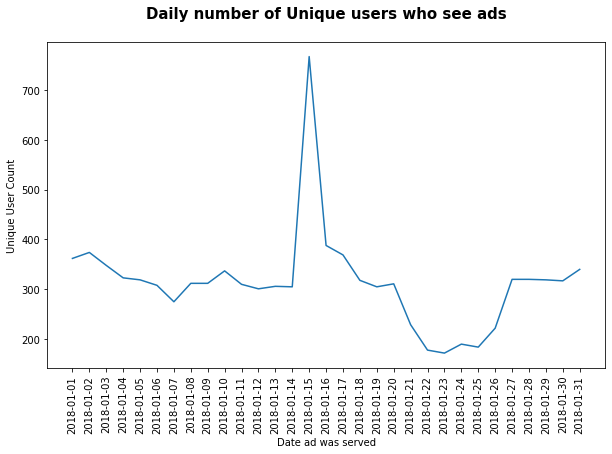

In [23]:
plt.figure(figsize=(10,6))

# Plot
plt.plot(df.groupby('date_served')['user_id'].nunique())

# Annotate
# Want to see all the dates along the x-axis
plt.xticks(df.groupby('date_served')['user_id'].nunique().index)
# Rotate to see better
plt.xticks(rotation=90)
plt.ylabel('Unique User Count')
plt.xlabel('Date ad was served')
plt.title('Daily number of Unique users who see ads\n', size=15, fontweight="bold")
plt.show()

*Based on above, `perhaps a marketing email or the sorts was sent on the day we see a spike`*

---

## Common Marketing Metrics
- These are typically used to measure marketing campaign success


### 1. Conversion Rate
- For a marketing team, typically a campaign's success is measured by a `Conversion Rate`
- Definition: Of all the people who came in contact with the marketing campaign, how many bought the product? i.e., depending on the business, did a person make a purchase or subscribed to the service.
- Conversion Rate = # of people who convert / Total # of people we marketed to

In [24]:
# Calculate the total number of people who converted

df[df['converted']==True]
df['converted'].value_counts(dropna=False)

False    8946
True     1076
NaN        15
Name: converted, dtype: int64

In [25]:
# Users who converted
subscribers = df[df['converted']==True]['user_id'].nunique()
print(f"{'# of people who converted':<{pad}}: {subscribers}")

# Total # of users
total = df['user_id'].nunique()
print(f"{'Total # of users':<{pad}}: {total}")

# Conversion Rate
total_conversion_rate = subscribers / total
print(f"\n{'Conversion Rate':<{pad}}: {round(total_conversion_rate*100,2)} %")


# of people who converted                         : 1015
Total # of users                                  : 7309

Conversion Rate                                   : 13.89 %


### 2. Retention Rate
- Definition: Once a user has signed up for a subscription, are they still a subscriber 1, 3, 23 months in?
- This metric requires patience since we cannot know 90-day retention rates until 90 days have passed since the user initially subscribed
- Retention Rate = # of people who remain subscribed / Total # of people who converted

In [26]:
# In this case, we'll calculate retention over 1 month
retained = df[df['is_retained']==True]['user_id'].nunique()
print(f"{'# of people remained subscribed over 1 month':<{pad}}: {retained}")

# Retention Rate
rentention_rate =  retained / subscribers
print(f"\n{'Retention Rate':<{pad}}: {round(rentention_rate*100,2)} %")

# of people remained subscribed over 1 month      : 678

Retention Rate                                    : 66.8 %


### 3. Customer Segmentation
- It's important to understand how we are marketing to
- Customer segmentation is done based on specific characteristics (e.g. Age group, Gender, Location, past interation with the business, marketing channels users interacted with, etc.)
- This segmentation also helps in breaking down metrics to the customer segment in case we want to further investigate the metrics based on the customer segments that matter most to the business
- Customer segmentation can help marketing teams evaluate and propose different marketing techniques that are tailored to a segment for the biggest bang for the buck.


#### Customer Segmentation by subscribing channel

In [27]:
# Lets check the retention rate of users that clicked on a House ad subscribing channel
# Subsequently, we'll calculate retention rate amoung different subscribing channels

# Below is the sample data for the House Ads segmentation
df[df['subscribing_channel']=='House Ads'].head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,day_served
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True,0.0
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True,0.0
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True,0.0
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True,0.0


In [28]:
# Number of subscribers by subscribing channel

sub_by_channel = df[df['converted']==True].groupby('subscribing_channel')['user_id'].nunique()
sub_by_channel

subscribing_channel
Email        161
Facebook     221
House Ads    298
Instagram    232
Push          77
Name: user_id, dtype: int64

In [29]:
# Number of retained people by subscribing channel

ret_by_channel = df[df['is_retained']==True].groupby('subscribing_channel')['user_id'].nunique()
ret_by_channel

subscribing_channel
Email        141
Facebook     152
House Ads    173
Instagram    158
Push          54
Name: user_id, dtype: int64

In [30]:
channel_retention_rate = round(((ret_by_channel/sub_by_channel)*100),1)
channel_retention_rate

subscribing_channel
Email        87.6
Facebook     68.8
House Ads    58.1
Instagram    68.1
Push         70.1
Name: user_id, dtype: float64

*`Email` has the highest retention rate among the marketing channels*

## Plotting Campaign results

### 1. Conversion by Language

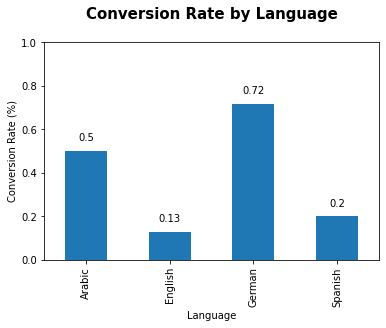

In [31]:
# Get the subscribers by language
sub_by_lang = df[df['converted']==True].groupby('language_displayed')['user_id'].nunique()

# Total unique users by langauage 
# Group by language and count unique users
total_by_lang = df.groupby('language_displayed')['user_id'].nunique()

# Conversion rate for all languages
lang_conversion_rate = (sub_by_lang/total_by_lang)

# Plot results
# plt.figure(figsize=(10,8))
lang_conversion_rate.plot(kind='bar')

# Annotate
plt.xlabel('Language')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Language\n', size=15, fontweight='bold')
plt.ylim(0,1)

for x,y in enumerate(lang_conversion_rate):
    label = round(y,2)
    plt.annotate(
        label, 
        (x,y), 
        textcoords="offset points", 
        xytext=(0,10),
        ha='center') 

plt.show()

### 2. Subscriber Quality

- Essentially, we are doing a simple form of cohort analysis that helps us evaluate the quality of subscribers we're bringing in each day
- Here we are basically calculating the retention rate (retained / converted) by subscription date (i.e.,  for the data grouped on the subscription date)
- If we see this metric trend upward overtime, it could mean that: 
    1. the business is getting better at converting users who are genuinely interested in the product
    2. we're improving our onboarding process once users subscribe

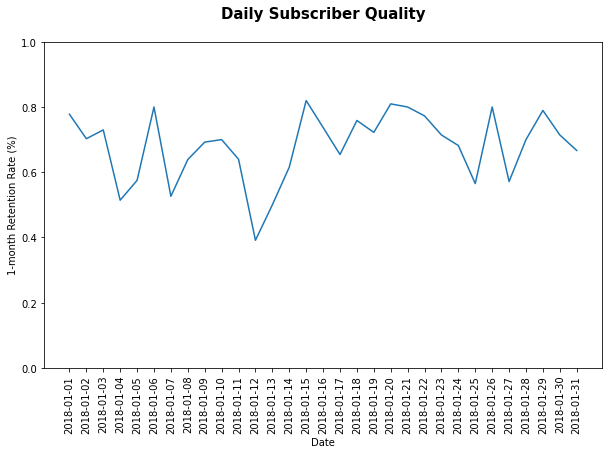

In [32]:
# Daily Retention Rate
daily_retention_rate = retention_rate(df, 'date_subscribed')

# Plot
plt.figure(figsize=(10,6))
plt.plot(daily_retention_rate)
plt.xticks(daily_retention_rate.index)

# Annotate
plt.xlabel('Date')
plt.ylabel('1-month Retention Rate (%)')
plt.title('Daily Subscriber Quality\n', size=15, fontweight='bold')
plt.xticks(rotation=90)

# set the limits from 0 to 1 to get an accurate 
# understanding and not get swayed by automatic 
# matplotlib axis and its corresponding interpretation
plt.ylim(0, 1)  

plt.show()

*If this chart were to trend downward, it would imply that we have an unfavorable customer churn since we are retaining lesser customers*

### 3. Retention Rate by channel

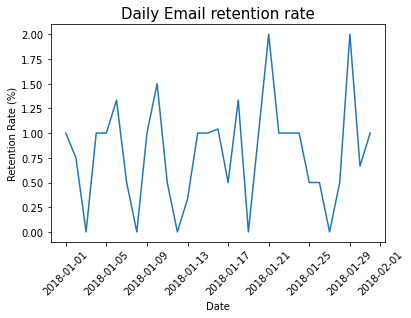

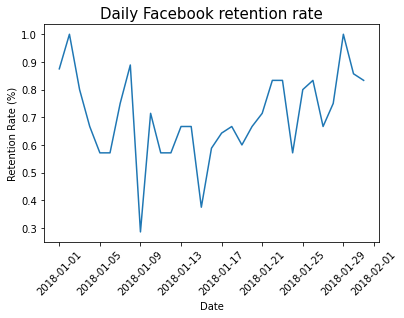

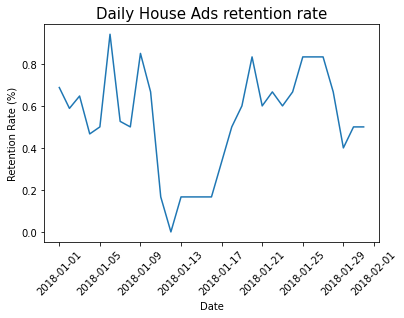

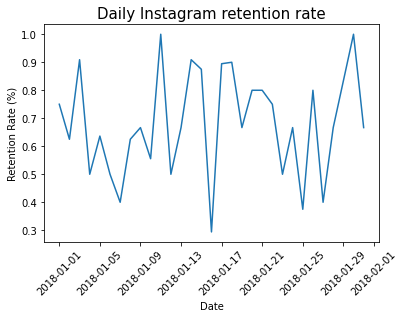

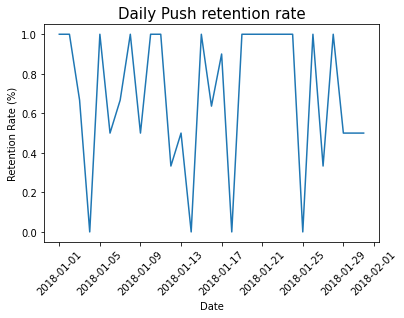

In [33]:
retention_by_channel = retention_rate(df, ['date_subscribed', 'subscribing_channel'])
retention_by_channel.unstack(level=1).fillna(value=0)

plotting_various_retention_rates(retention_by_channel.unstack(level=1).fillna(value=0))

- Typically, ads (especially Email) sent in bulk lead users to subscribe on the `same set of limited days`, hence the spikes and dips.
    *When retention rate is 0, it means no one subscribed on those days.*

### 4. Langauage Preference by age group

- Understanding which customer segments (age groups) prefer which language

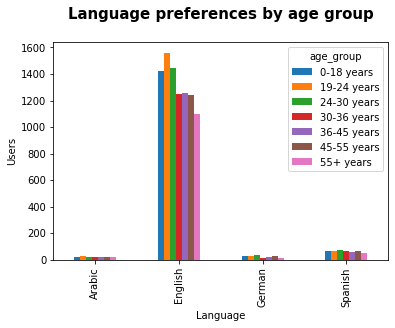

In [34]:
# Group by language preferred and age group
# and count the number of records

lang_age_grp = df.groupby(['language_preferred', 'age_group'])['user_id'].count()
lang_age_grp  # isn't the best format for plotting a bar graph. Unstack it.

# Unstacking
lang_age_grp_df = pd.DataFrame(lang_age_grp.unstack(level=1))

# Plot
lang_age_grp_df.plot(kind='bar')

# Annotate
plt.title('Language preferences by age group\n', size=15, fontweight='bold')
plt.xlabel('Language')
plt.ylabel('Users')
plt.show()

### 5. Conversion Rate by Age

In [35]:
# age_group_conv = retention_rate(df, ['date_served','age_group'])
age_group_conv = conversion_rate(df, ['date_served','age_group'])

age_group_conv

date_served  age_group  
2018-01-01   0-18 years     0.008867
             19-24 years    0.011823
             24-30 years    0.005911
             30-36 years    0.001970
             36-45 years    0.001970
                              ...   
2018-01-31   19-24 years    0.005911
             24-30 years    0.002956
             36-45 years    0.001970
             45-55 years    0.000985
             55+ years      0.000985
Name: user_id, Length: 195, dtype: float64

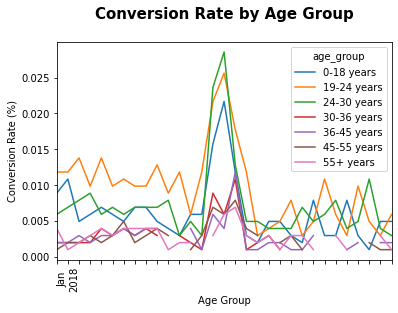

In [36]:
age_group_conv = conversion_rate(df, ['date_served','age_group'])

# Unstack and create df
age_group_conv_df = pd.DataFrame(age_group_conv.unstack(level=1))

# Plot
age_group_conv_df.plot(kind='line')

# Annotate
plt.title('Conversion Rate by Age Group\n', size=15, fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Conversion Rate (%)')
plt.xticks(age_group_conv_df.index)
plt.xticks(rotation=90)
plt.show()

*The above can be a **`report to the Marketing stakeholders on a monthly basis`** that can be refreshed.*

### 6. Day of week trends and inconsistencies

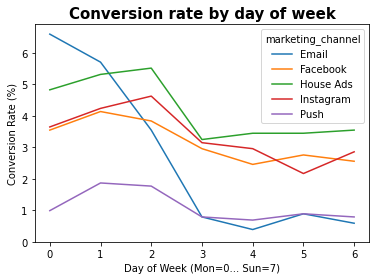

In [37]:
dow_conversion = conversion_rate(df, ['day_served', 'marketing_channel'])
dow_conversion = round((dow_conversion*100),2)
dow_conversion_df = pd.DataFrame(dow_conversion.unstack(level=1))
dow_conversion_df.plot()
plt.title('Conversion rate by day of week', size=15, fontweight='bold')
plt.xlabel('Day of Week (Mon=0... Sun=7)')
plt.ylabel('Conversion Rate (%)')
plt.ylim(0)
plt.show()

*`Prospects respond best to Email ad campaigns at the start of the week`*

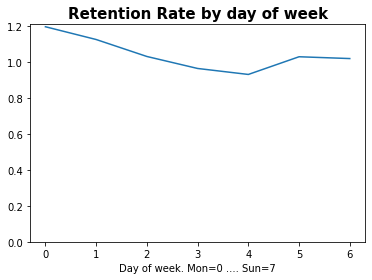

In [38]:
# Get retention rate by day of week the ad was served
dow_retention = retention_rate(df, ['day_served'])

# Plot
dow_retention.plot()
plt.title('Retention Rate by day of week', size=15, fontweight='bold')
plt.ylim(0)
plt.xlabel('Day of week. Mon=0 .... Sun=7')
plt.show()

*Some business **`consistently perform better on weekdays than on weekends`**.*
This might be indicative on when business should attempt to market to customers most heavily.

### 7. House-Ads Conversion Rate

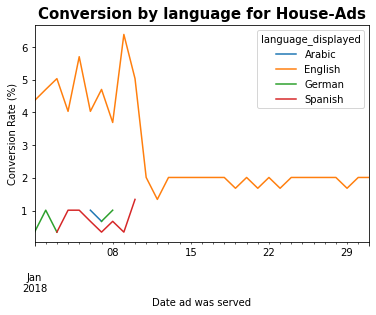

In [39]:
house_ads_df = df[df['marketing_channel']=='House Ads'].copy()
conv_lang_channel = conversion_rate(house_ads_df, ['date_served','language_displayed'])
conv_lang_channel = round((conv_lang_channel*100),2)
conv_lang_channel_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Plot
conv_lang_channel_df.plot()
plt.title('Conversion by language for House-Ads', size=15, fontweight='bold')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Date ad was served')
plt.show()

*The **`sudden dip`** is a result of ads being served in the **`wrong language preference`**.*

In [40]:
house_ads_df['is_correct_lang'] = np.where(house_ads_df['language_preferred']==house_ads_df['language_displayed'], True, False)
print(f"There are {house_ads_df[house_ads_df['is_correct_lang']==False].shape[0]} users whose preferred langauge does not match the ad in which the language was served.")

There are 453 users whose preferred langauge does not match the ad in which the language was served.


---

## Key Outcomes / Notes:


- `100K samples` assessed
- `7309 unique users`
- `31 days of marketing campaigns`
- On an average, `~300 users see a marketing campaign each day`
- `Conversation Rate` for entire duration of marketing campaigns = `13.09%`
- `1-month Retention Rate = 66.8%`
- `House-Ads was the most effective subscribing channel` (among Email, Facebook, Instagram and Push) contributing to the highest conversion and retention rates.
- `English was the most preferred language`, especially in the subscriber age group of 19-24 years
- Prospects in `age group 24-30 years converted the most`
- `Monday, Tuesday and Wednesday` were the days of the week that saw `most conversion and retention`
- There are `453 users whose preferred langauge does not match the ad in which the language was served`. This led to a `significant dip in conversion rate`, which is to be resolved with data correction

---